# GLM models - variables non PCA - Gdansk

In [1]:
%matplotlib inline
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from __future__ import print_function
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels import graphics
from statsmodels.graphics.api import abline_plot
from scipy import stats
from matplotlib import pyplot as plt
import warnings
import itertools
import seaborn as sns
from sklearn.metrics import r2_score
warnings.filterwarnings("ignore")
import math
import functools 
import operator

In [2]:
def convertTuple(tup): 
    str = functools.reduce(operator.add, (tup)) 
    return str

In [3]:
sns.set_style("whitegrid")
plt.rcParams['figure.figsize']=(18,10)

In [4]:
data = pd.read_pickle('data/gdansk_journeys.pkl')

In [5]:
data = data.groupby('Date').agg({'Journeys':'sum','Visibility':'mean', 'Cloud_cover':'mean', 'Wind_speed':'mean',
       'Temperature':'mean', 'Pressure':'mean', 'Precipitation':'mean', 'Insolation':'mean',
       'comp_0':'mean', 'comp_1':'mean', 'comp_2':'mean', 'comp_3':'mean', 'comp_4':'mean', 'comp_5':'mean', 'comp_6':'mean','Season':'mean'}).reset_index()

In [6]:
gdansk = data.copy()
gdansk.Date = pd.to_datetime(gdansk.Date)

In [7]:
gdansk

,Date,Journeys,Visibility,Cloud_cover,Wind_speed,Temperature,Pressure,Precipitation,Insolation,comp_0,comp_1,comp_2,comp_3,comp_4,comp_5,comp_6,Season
0,2019-01-01,1709.0,16424.041667,7.291667,6.750000,5.254167,1003.329167,0.108333,0.008333,2.064953,-0.090731,1.730253,0.091164,-0.160534,0.207104,0.026939,4
1,2019-01-02,2827.0,13396.958333,7.000000,9.583333,1.745833,1010.445833,0.304167,0.000000,2.729497,-0.248112,2.953825,1.679296,1.240689,1.201303,0.041106,4
2,2019-01-03,2569.0,14534.375000,6.375000,8.083333,0.745833,1023.779167,0.108333,0.037500,1.639283,-1.514963,1.628361,1.842365,0.265598,1.065210,-0.028207,4
3,2019-01-04,3660.0,14277.708333,7.583333,3.416667,0.491667,1018.712500,0.012500,0.000000,1.596129,-0.712716,-0.952262,0.809846,-0.872172,-0.369892,0.240891,4
4,2019-01-05,3117.0,18373.666667,6.875000,6.375000,3.141667,1012.979167,0.129167,0.100000,1.324296,-0.372210,1.473866,0.980655,-0.224083,0.013836,0.322940,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,2019-12-27,3938.0,16893.833333,6.625000,5.250000,3.366667,1023.658333,0.287500,0.025000,1.221087,0.353098,0.543475,2.399517,0.071629,0.041645,-0.019640,4
361,2019-12-28,3605.0,19227.666667,6.500000,7.041667,2.300000,1035.379167,0.054167,0.000000,0.749617,-1.724077,1.145295,2.600335,-0.956946,0.810163,-0.213962,4
362,2019-12-29,4499.0,19928.958333,6.666667,4.250000,1.758333,1034.991667,0.000000,0.054167,0.245561,-1.388983,-0.362840,2.172542,-1.497169,-0.119435,0.082199,4
363,2019-12-30,6721.0,20000.000000,6.333333,5.375000,3.925000,1019.250000,0.000000,0.000000,0.845959,-1.004914,0.756577,0.956642,-1.129472,-0.206957,-0.270946,4


## Distribution of the dependent variable - Journeys

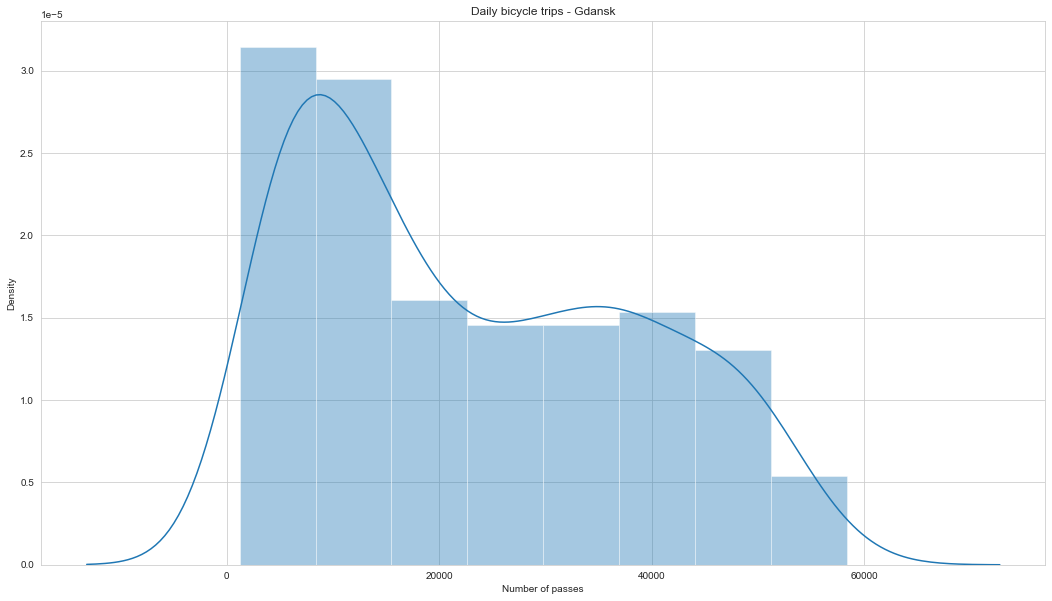

In [8]:
sns.distplot(gdansk.Journeys, kde=True)
plt.title('Daily bicycle trips - Gdansk')
plt.xlabel('Number of passes')
plt.show()

### The above distribution is closest to the Inverse Gaussian, Gamma (or Poisson) distribution

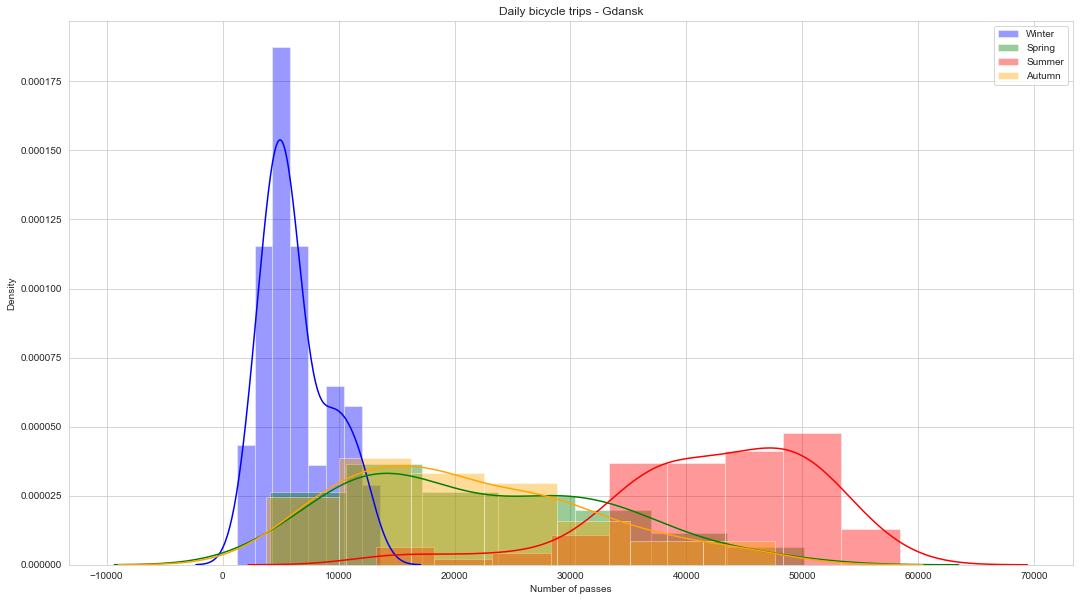

In [9]:
fig, ax = plt.subplots()
ax = sns.distplot(gdansk.Journeys[gdansk.Season == 4], kde=True, label='Winter', color='blue')
ax = sns.distplot(gdansk.Journeys[gdansk.Season == 1], kde=True, label='Spring', color='green')
ax = sns.distplot(gdansk.Journeys[gdansk.Season == 2], kde=True, label='Summer', color='red')
ax = sns.distplot(gdansk.Journeys[gdansk.Season == 3], kde=True, label='Autumn', color='orange')
plt.title('Daily bicycle trips - Gdansk')
plt.legend()
plt.xlabel('Number of passes')
plt.show()

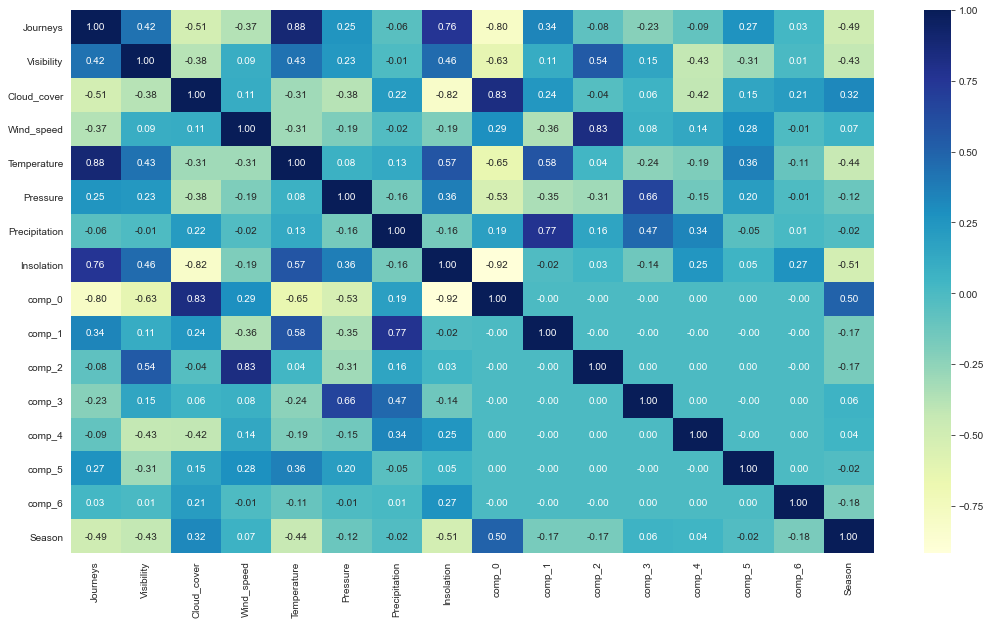

In [10]:
_ = sns.heatmap(gdansk.corr(), cmap="YlGnBu", fmt='.2f', annot = True)

## Data modeling

In [11]:
columns = ['comp_0 ', 'comp_1 ']

help_t = []
for i in range(0, len(columns)+1):
        for subset in itertools.combinations(columns, i):
                help_t.append(subset)                

formula =[]
for i in range(1,len(help_t)):
    x = convertTuple(help_t[i])
    f = '%s' % x
    g = f.split(' ')
    h=''
    h = ' + '.join(g)[:-3]
    formula.append(h)

#### GLM models

In [12]:
familia = [sm.families.Gaussian(link=sm.families.links.log()),
           
           sm.families.InverseGaussian(link=sm.families.links.identity()),
           sm.families.InverseGaussian(link=sm.families.links.log()),
           
           sm.families.Gamma(link=sm.families.links.identity()),
           sm.families.Gamma(link=sm.families.links.log()),
           
           sm.families.Poisson(link=sm.families.links.identity()),
           sm.families.Poisson(link=sm.families.links.log())          
          ]
familia2 = ['Gaussian','Inverse Gaussian','Inverse Gaussian','Gamma','Gamma','Poisson','Poisson']

Model No. 1



                 Generalized Linear Model Regression Results                  
Dep. Variable:               Journeys   No. Observations:                  365
Model:                            GLM   Df Residuals:                      363
Model Family:                Gaussian   Df Model:                            1
Link Function:                    log   Scale:                      9.1467e+07
Method:                          IRLS   Log-Likelihood:                -3862.4
Date:                Thu, 26 Aug 2021   Deviance:                   3.3202e+10
Time:                        17:00:42   Pearson chi2:                 3.32e+10
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.9361      0.028    3

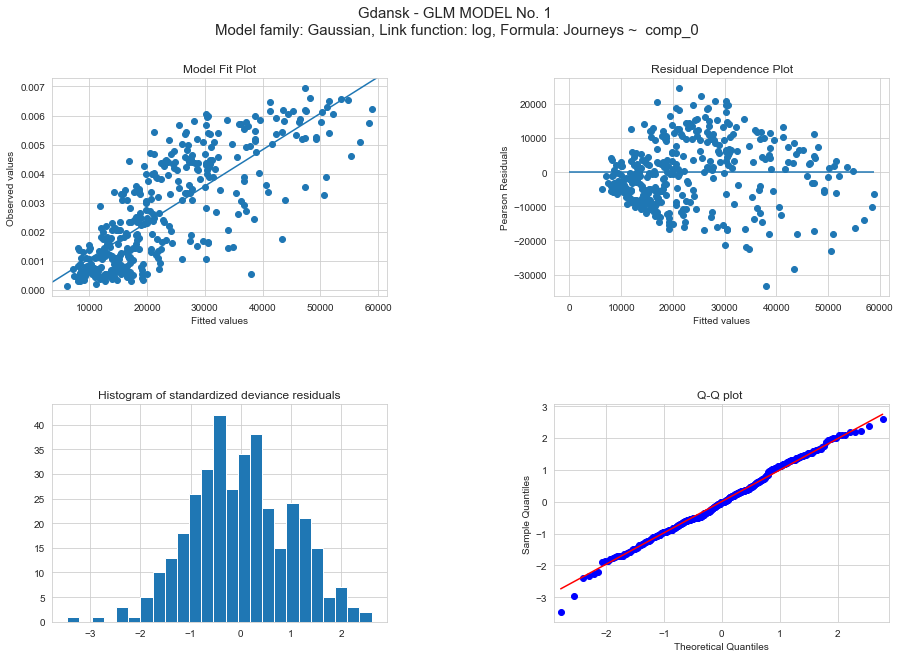

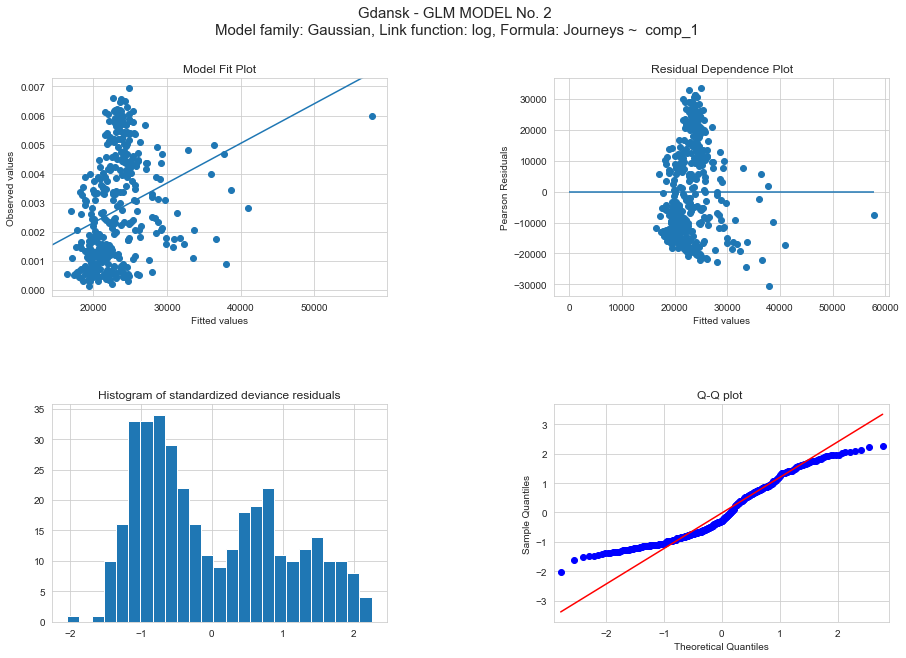

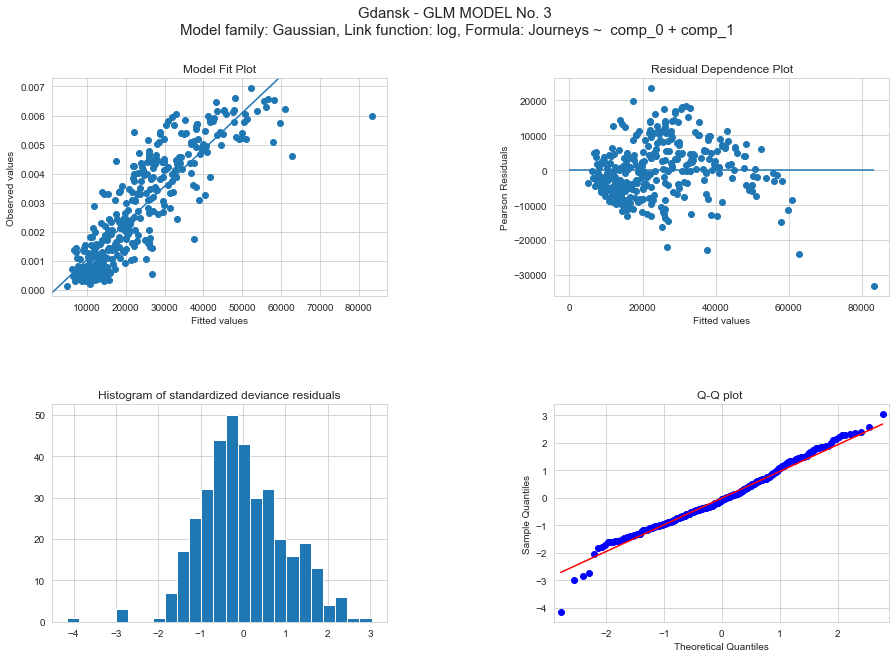

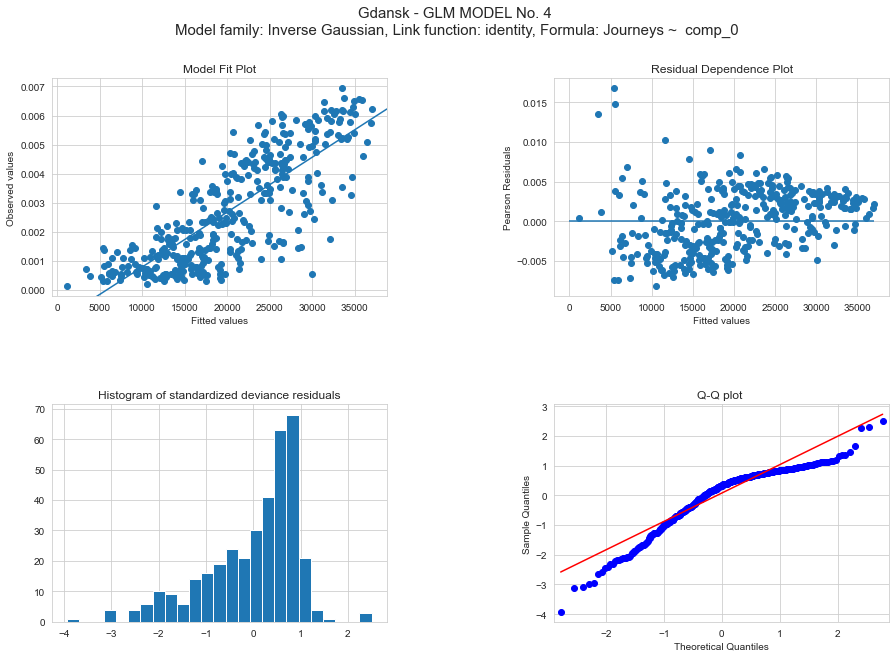

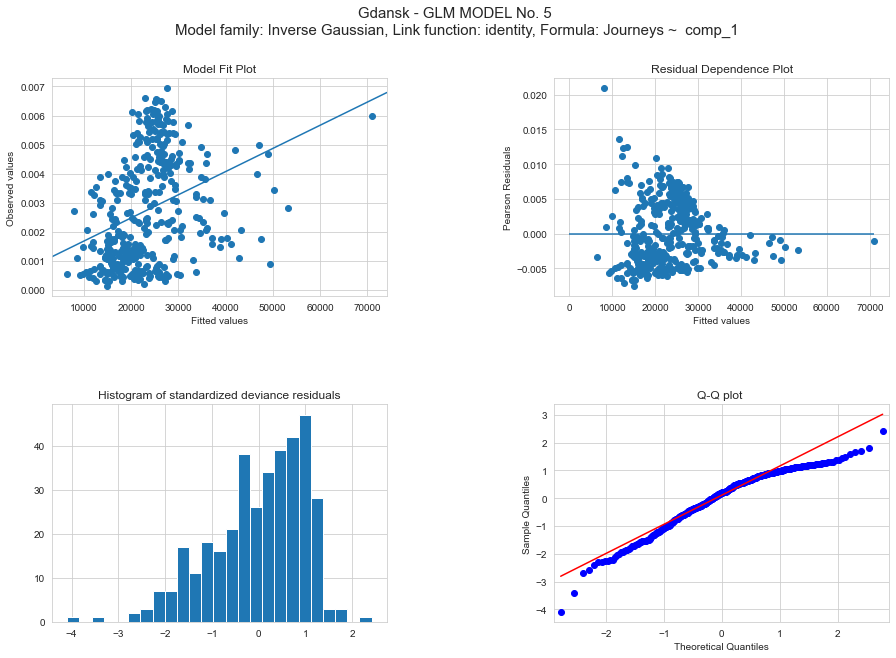

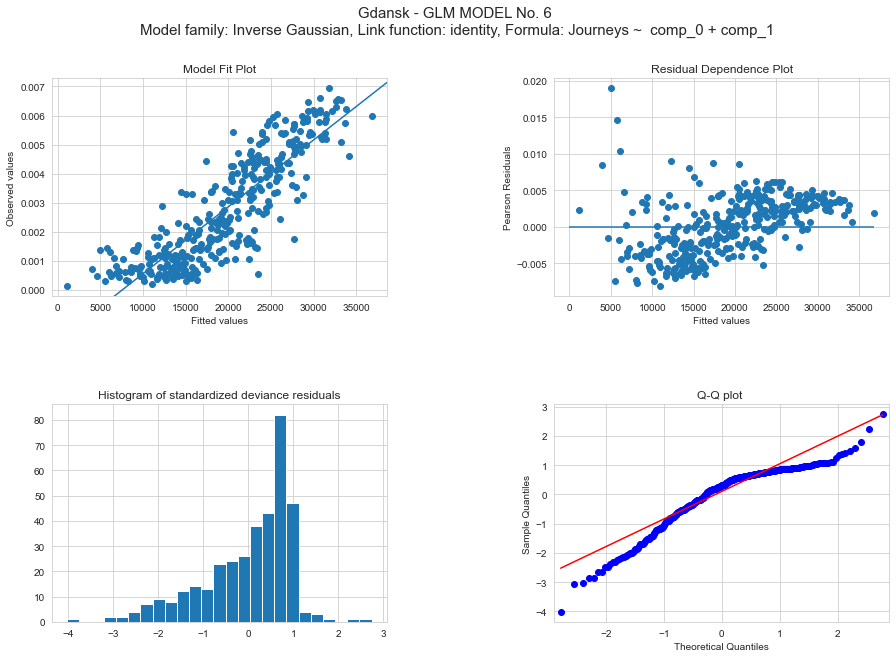

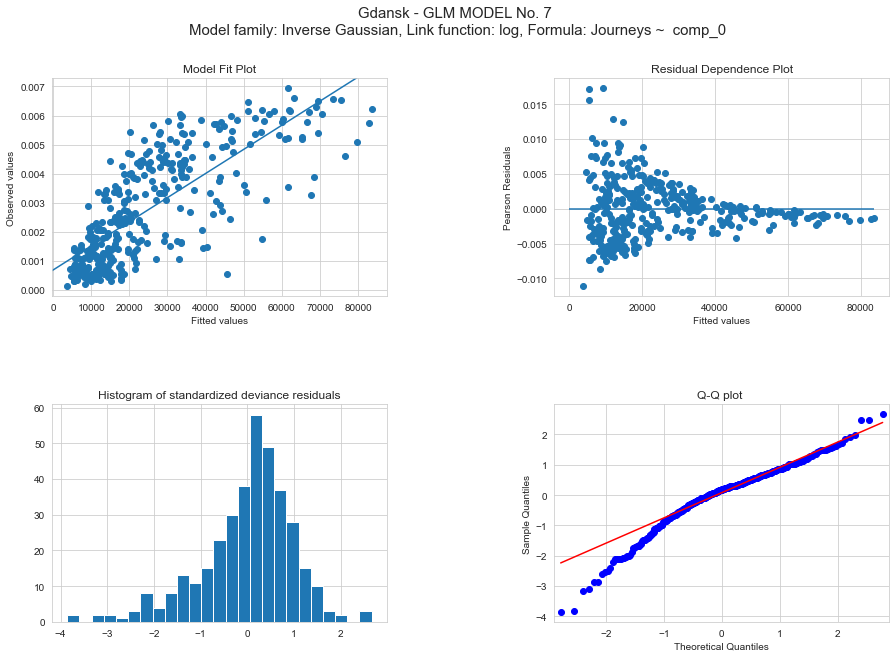

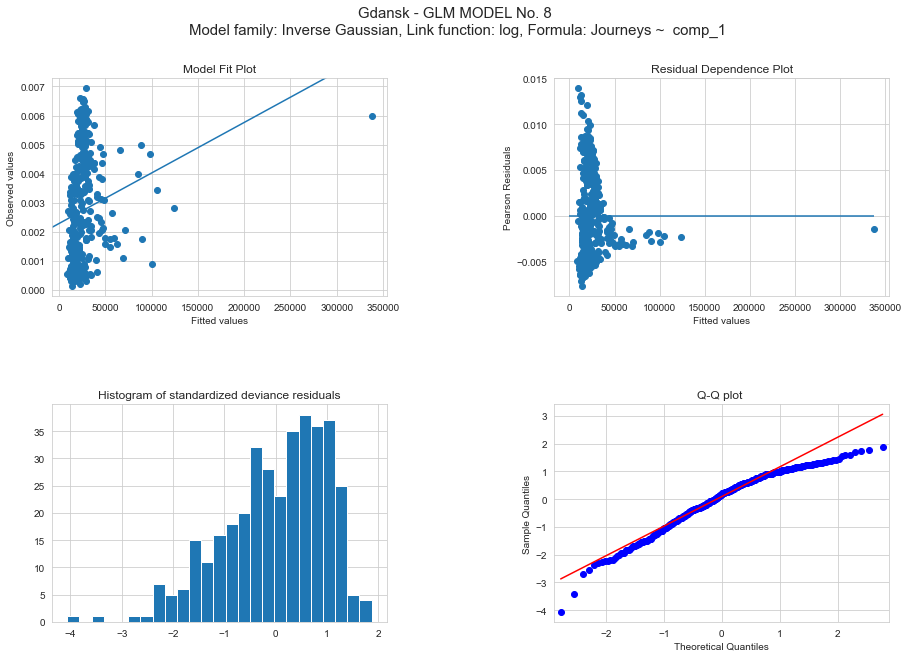

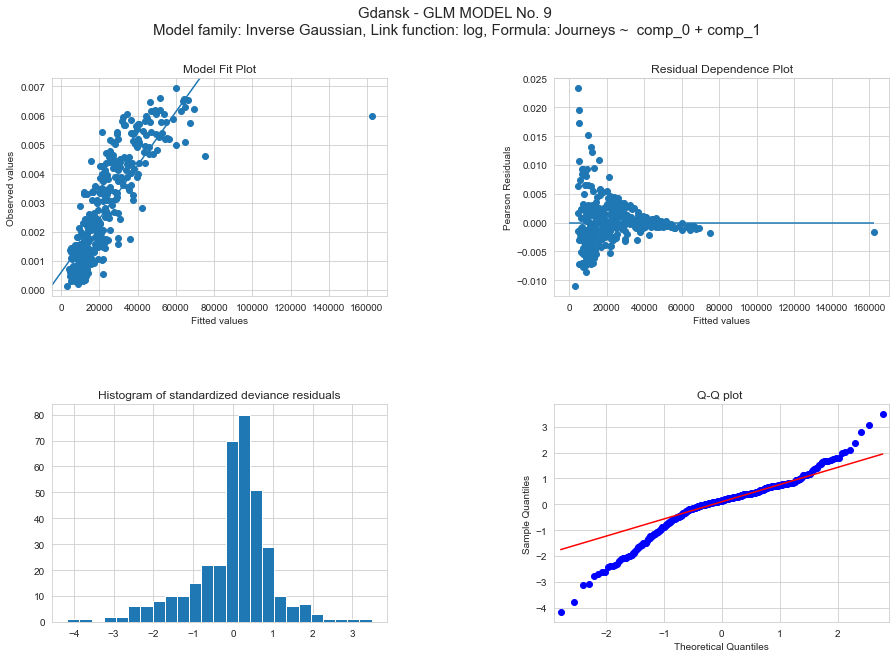

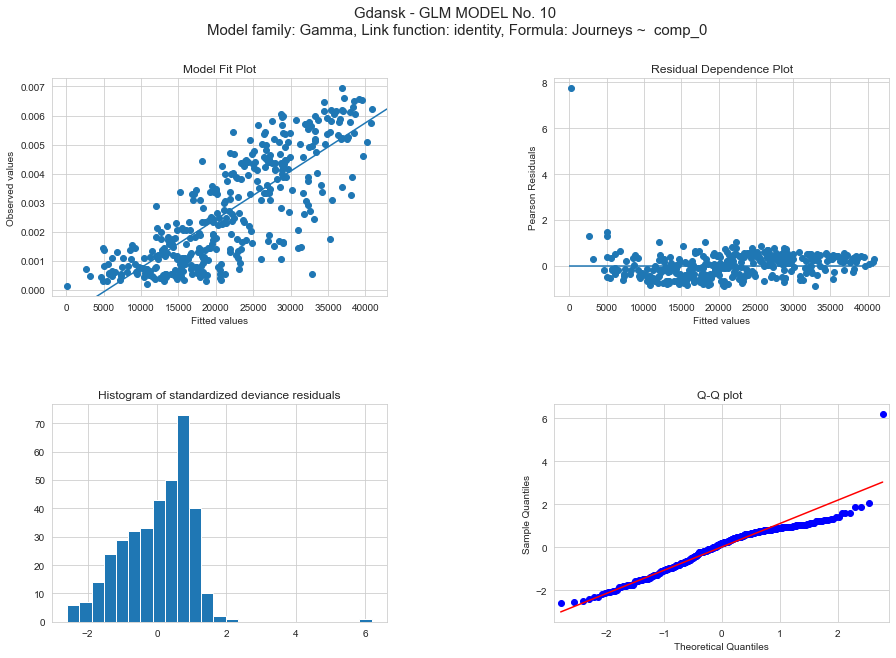

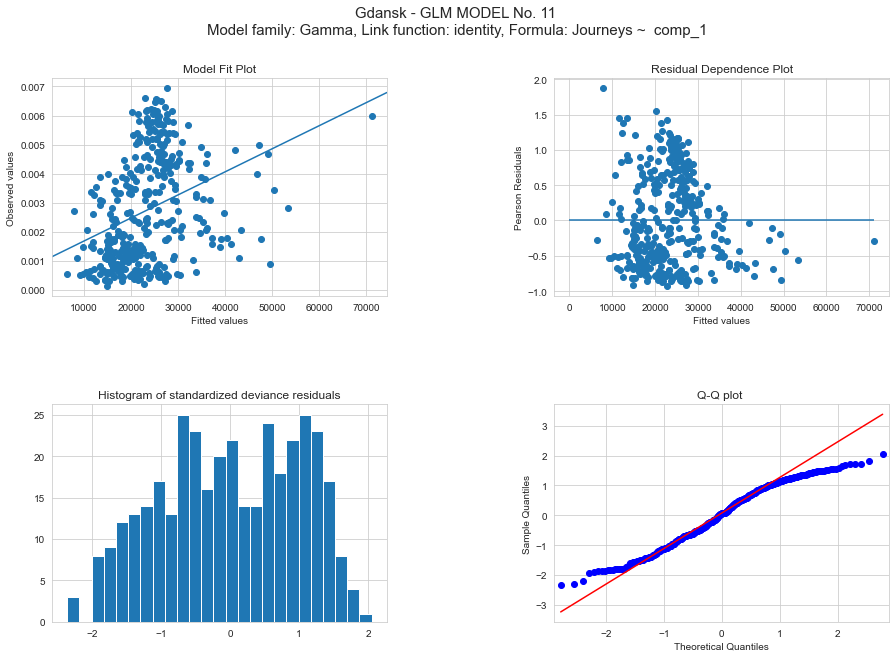

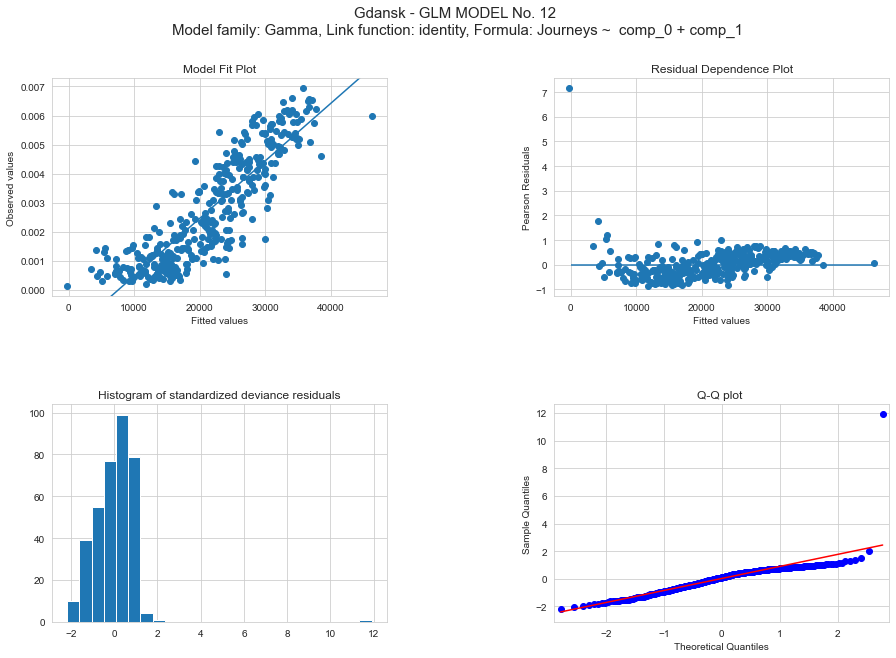

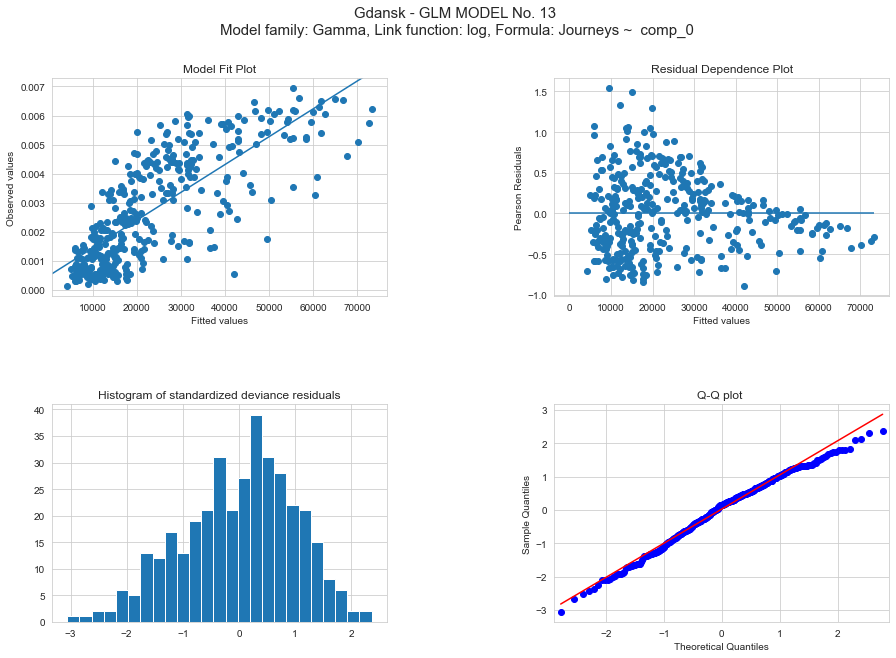

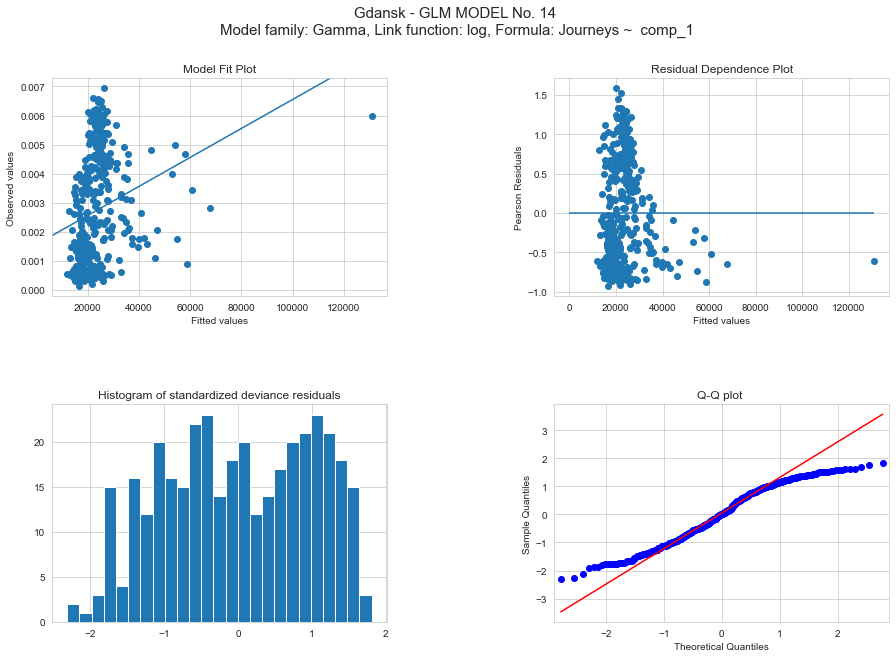

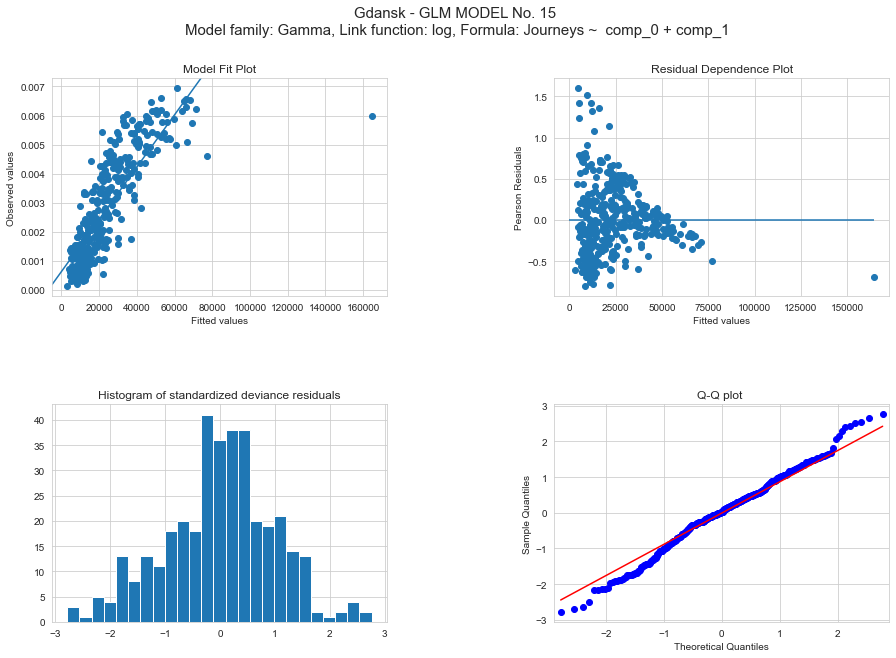

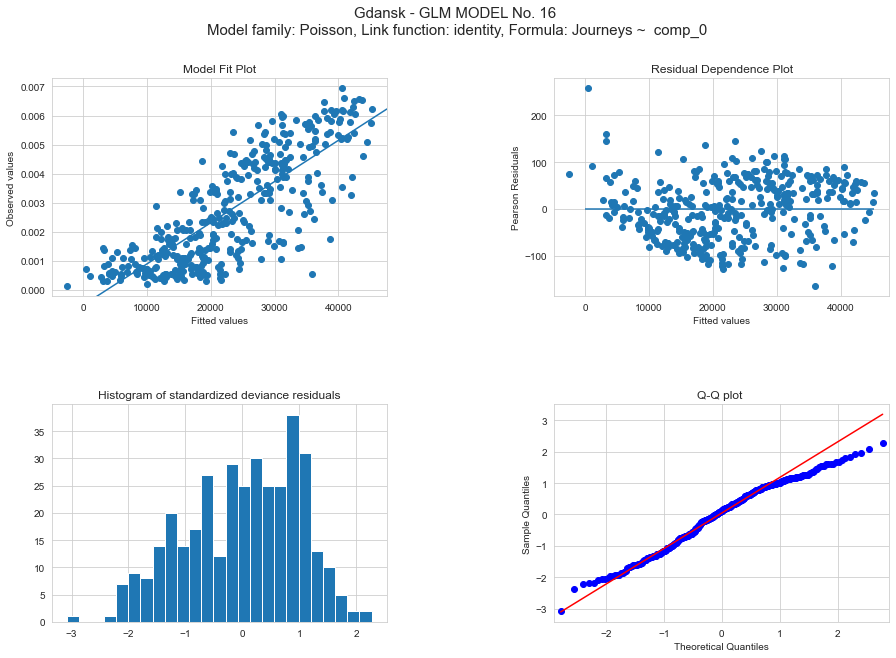

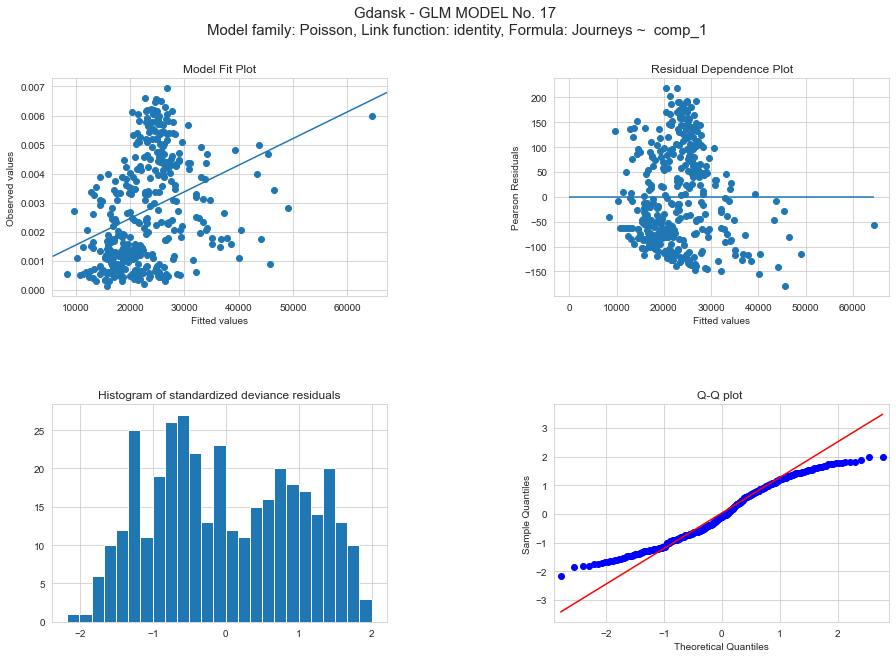

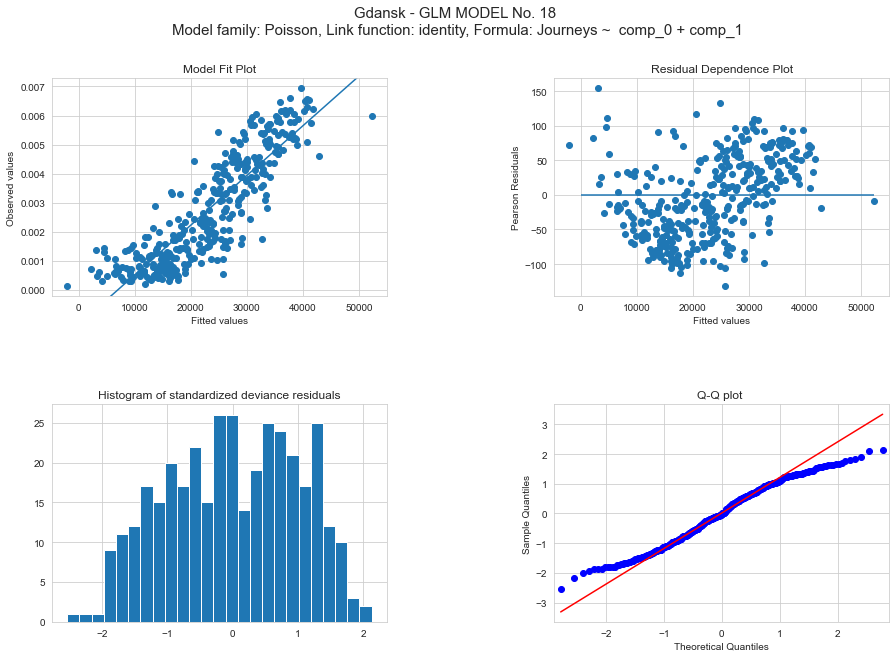

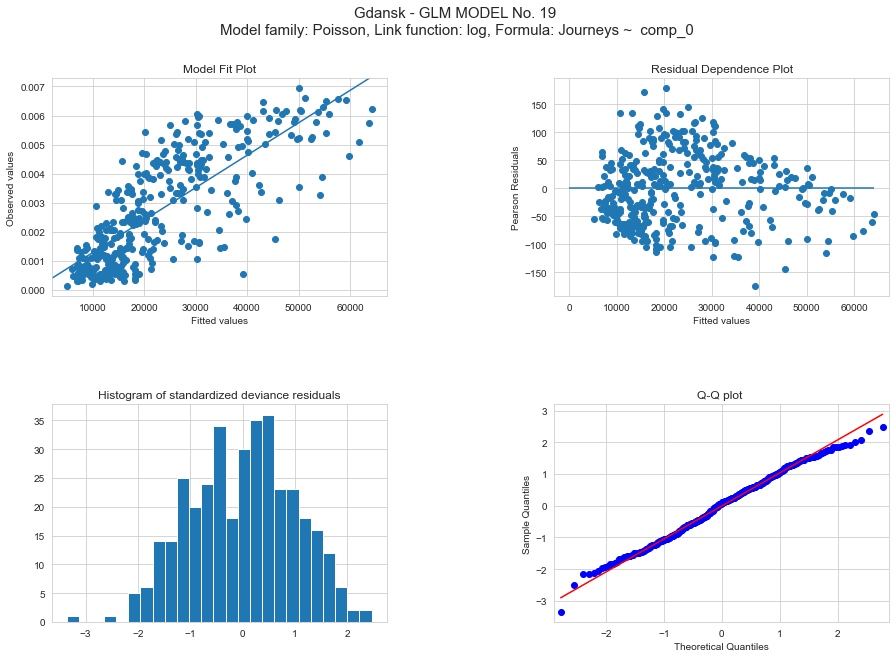

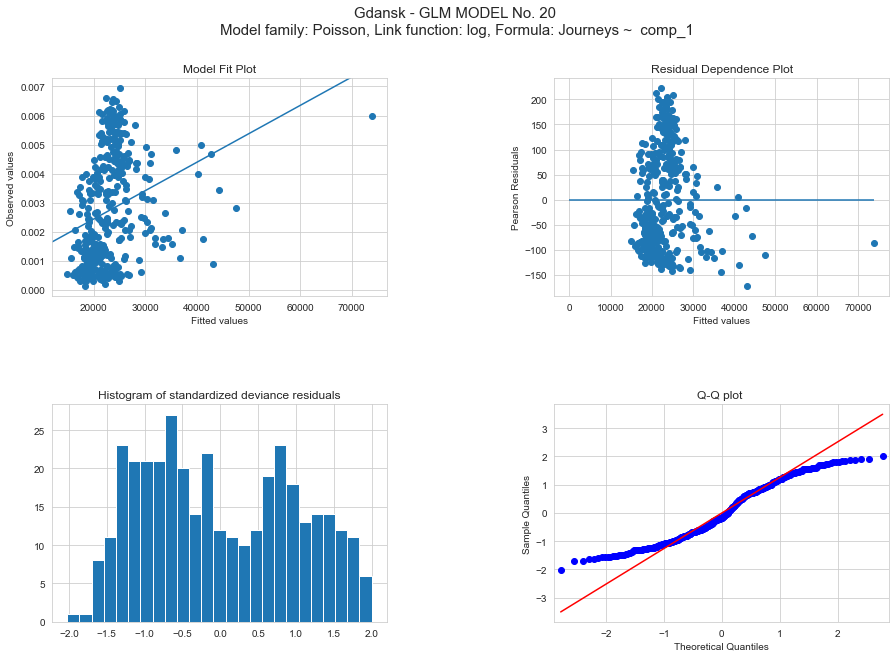

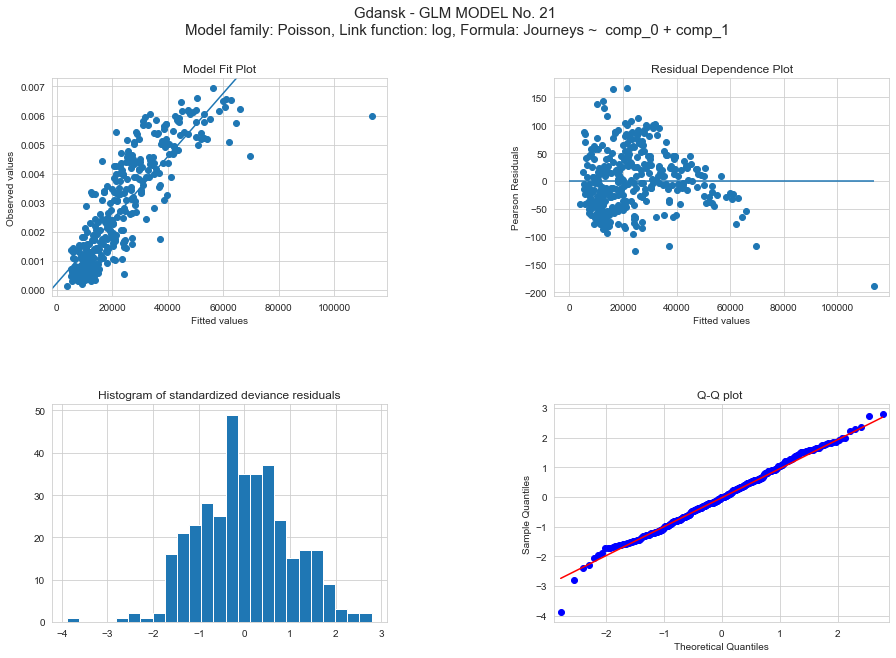

In [13]:
explained_variable = gdansk.Journeys
constant = 'Journeys ~ '
result_table = []
a=1
y = explained_variable[:,]/explained_variable.sum()

for i in range(0,len(familia)):
    for x in range(0,len(formula)):
        print('Model No.',a)
        mod = smf.glm(formula=constant+formula[x], data=gdansk, family=familia[i]).fit()
        yhat = mod.mu
        form = formula[x]
        result_table.append([f'Model No. {a}',form,(math.sqrt(mod.df_resid/abs(mod.deviance))),round(mod.aic,2), r2_score(explained_variable,mod.mu), familia2[i], mod.summary2().tables[0][1][1]])
        print('\n\n')
        print(mod.summary())
        #### Wykresy ----------------------------------------------------------------------------
        figGLM = plt.figure(figsize=[15,10])
        plt.subplots_adjust(wspace=0.5, hspace=0.5)
        plt.suptitle(f'Gdansk - GLM MODEL No. {a} \nModel family: {familia2[i]}, Link function: {mod.summary2().tables[0][1][1]}, Formula: {constant} {form}', fontsize=15)

        ax1GLM = figGLM.add_subplot(221)
        ax1GLM.scatter(yhat, y)
        line_fit = sm.OLS(y, sm.add_constant(yhat, prepend=True)).fit()
        abline_plot(model_results=line_fit, ax=ax1GLM)
        ax1GLM.set_title('Model Fit Plot')
        ax1GLM.set_ylabel('Observed values')
        ax1GLM.set_xlabel('Fitted values')

        ax2GLM = figGLM.add_subplot(222)
        ax2GLM.scatter(yhat, mod.resid_pearson)
        ax2GLM.hlines(0, 0, yhat.max())
        ax2GLM.set_title('Residual Dependence Plot')
        ax2GLM.set_ylabel('Pearson Residuals')
        ax2GLM.set_xlabel('Fitted values')

        ax3GLM = figGLM.add_subplot(223)
        resid = mod.resid_deviance.copy()
        resid_std = stats.zscore(resid)
        ax3GLM.hist(resid_std, bins=25)
        ax3GLM.set_title('Histogram of standardized deviance residuals')

        ax4GLM = figGLM.add_subplot(224)
        ax4GLM.set_title('Q-Q plot ')
        sm.qqplot(resid, fit = True, line='q', ax = ax4GLM)
        plt.plot()
        print('AIC: ',round(mod.aic,2),'McFadden: ',r2_score(explained_variable,mod.mu))
        print('\n\n')
        a += 1

In [14]:
result_GLM = pd.DataFrame(result_table)

In [15]:
result_GLM.rename(columns={0:'Model',1:'Formula',2:'residuals_std_dev',3:'AIC',4:'McFadden',5:'Family',6:'Link'},inplace=True)

In [16]:
result_GLM.loc[result_GLM.AIC.isnull()]

,Model,Formula,residuals_std_dev,AIC,McFadden,Family,Link
15,Model No. 16,comp_0,0.015638,NaN,0.627759,Poisson,identity
17,Model No. 18,comp_0 + comp_1,0.016951,NaN,0.688504,Poisson,identity


In [17]:
result_GLM.sort_values(['AIC','McFadden'], ascending=[True,False]).head(10)

,Model,Formula,residuals_std_dev,AIC,McFadden,Family,Link
14,Model No. 15,comp_0 + comp_1,2.273176,7562.01,0.597649,Gamma,log
2,Model No. 3,comp_0 + comp_1,0.000126,7592.64,0.743914,Gaussian,log
12,Model No. 13,comp_0,1.965275,7673.80,0.571456,Gamma,log
0,Model No. 1,comp_0,0.000105,7728.82,0.626054,Gaussian,log
9,Model No. 10,comp_0,1.783033,7756.13,0.587275,Gamma,identity
8,Model No. 9,comp_0 + comp_1,220.174107,7776.35,0.608995,Inverse Gaussian,log
6,Model No. 7,comp_0,205.429290,7845.11,0.474373,Inverse Gaussian,log
5,Model No. 6,comp_0 + comp_1,201.420613,7874.12,0.522849,Inverse Gaussian,identity
3,Model No. 4,comp_0,199.332699,7893.29,0.526577,Inverse Gaussian,identity
11,Model No. 12,comp_0 + comp_1,1.536751,7899.90,0.627335,Gamma,identity


CONCLUSION: The best GLM model (Model No.15) for Gdansk at full harvest did not achieve better results than the regular ML.

<hr>  